In [64]:
DET_NICKNAME = 'LW_f277w-f356w-f444w'
KERNEL = 'f444w'
APERSIZE = '0_7'

import sys, os

DIR_CONFIG = '/Volumes/External1/Projects/Current/UNCOVER/scripts/'
sys.path.insert(0, DIR_CONFIG)
from config import DIR_CATALOGS, DET_TYPE, FILTERS, TARGET_ZP, TRANSLATE_FNAME, DIR_OUTPUT

FULLDIR_CATALOGS = os.path.join(DIR_CATALOGS, f'{DET_NICKNAME}_{DET_TYPE}/{KERNEL}/')
translate_file = os.path.join(DIR_CONFIG, TRANSLATE_FNAME)


In [65]:
import eazy
print(eazy.__version__)

# Symlink templates & filters from the eazy-code repository
print('EAZYCODE = '+os.getenv('EAZYCODE'))

eazy.symlink_eazy_inputs() 

params = {}

params['CATALOG_FILE'] = os.path.join(FULLDIR_CATALOGS, f'{DET_NICKNAME}_K{KERNEL}_SCIREADY_{APERSIZE}_CATALOG.fits')
params['MAIN_OUTPUT_FILE'] = os.path.join(FULLDIR_CATALOGS, f'{DET_NICKNAME}_K{KERNEL}_SCIREADY_{APERSIZE}_CATALOG.eazypy')

params['APPLY_PRIOR'] = 'n'
params['PRIOR_ABZP'] = TARGET_ZP
params['MW_EBV'] = 0.0
params['CAT_HAS_EXTCORR'] = 'y'

params['Z_MAX'] = 20
params['Z_STEP'] = 0.1

params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

params['VERBOSITY'] = 1
ez = eazy.photoz.PhotoZ(translate_file=translate_file,
                              zeropoint_file=None, params=params,
                              load_prior=False, load_products=True)

0.5.2.dev45
EAZYCODE = /Users/jweaver/Projects/Common/software/eazy-photoz
/Users/jweaver/Projects/Common/software/eazy-py/eazy/data/templates -> ./templates
/Users/jweaver/Projects/Common/software/eazy-py/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest
Read default param file: /Users/jweaver/Projects/Common/software/eazy-py/eazy/data/zphot.param.default


FileNotFoundError: CATALOG_FILE (/Volumes/External1/Projects/Current/UNCOVER/data/vTest/catalogs/LW_f277w-f356w-f444w_noise-equal/f444w/LW_f277w-f356w-f444w_Kf444w_SCIREADY_0_7_CATALOG.fits) not found

UVJ classification

In [ ]:
import numpy as np

u_v = -2.5*np.log10(ez.zout['restU'] / ez.zout['restV'])
v_j = -2.5*np.log10(ez.zout['restV'] / ez.zout['restJ'])

def uvj_sel(v_j):
    ret = 0.72*v_j + 0.75
    ret[v_j >= 1.6] = 1E20
    ret[v_j < 0.9] = 1.4
    return ret

clas = np.nan * np.ones(len(ez.zout), dtype=int)
out = uvj_sel(v_j)
clas[u_v >= out] = 1 # QG
clas[u_v < out] = 0 # SF
clas[(u_v > 2.4) | (u_v < 0.0) | (v_j < -0.6)  | (v_j > 2.0)] = -1
clas[np.isnan(u_v) | np.isnan(v_j)] = -1

ez.zout['u_v'] = u_v
ez.zout['v_j'] = v_j
ez.zout['uvj_class'] = clas


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/pyth

Total Sample Properties

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


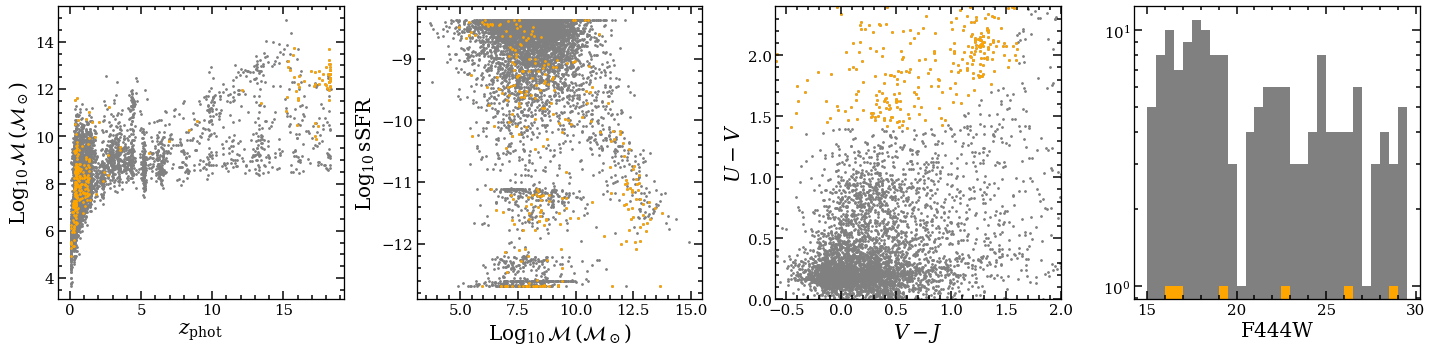

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(4*5, 5))

qg = ez.zout['uvj_class'] == 1
sanity = ez.cat['use_phot'] == 1

# z vs. M
axes[0].scatter(ez.zout['z_phot'][sanity], np.log10(ez.zout['mass'][sanity]), s=3, c='grey')
axes[0].scatter(ez.zout['z_phot'][qg & sanity], np.log10(ez.zout['mass'][qg & sanity]), s=3, c='orange')
axes[0].set(xlabel='$z_{\\rm phot}$', ylabel='Log$_{10}\,\mathcal{M}\,(\mathcal{M}_\odot)$')

# M vs. SFR
axes[1].scatter(np.log10(ez.zout['mass'][sanity]), np.log10(ez.zout['sfr']/ez.zout['mass'])[sanity], s=3, c='grey')
axes[1].scatter(np.log10(ez.zout['mass'][qg & sanity]), np.log10(ez.zout['sfr'][qg & sanity]/ez.zout['mass'][qg & sanity]), s=3, c='orange')
axes[1].set(xlabel='Log$_{10}\,\mathcal{M}\,(\mathcal{M}_\odot)$', ylabel='Log$_{10}\,{\\rm sSFR}}\,(\mathcal{M}_\odot\,{\\rm yr}^{-1})$')

# UVJ
axes[2].scatter(ez.zout['v_j'][sanity], ez.zout['u_v'][sanity], s=3, c='grey')
axes[2].scatter(ez.zout['v_j'][qg & sanity], ez.zout['u_v'][qg & sanity], s=3, c='orange')
axes[2].set(xlabel='$V-J$', ylabel='$U-V$', xlim=(-0.6, 2.0), ylim=(0, 2.4))

# F444W
bins = np.arange(15, 30, 0.5)
axes[3].hist(ez.cat['f_f444w'][sanity], bins=bins, color='grey')
axes[3].hist(ez.cat['f_f444w'][qg & sanity], bins=bins, color='orange')
axes[3].set(xlabel='F444W')
axes[3].semilogy()

fig.tight_layout()



Sample Selection

In [ ]:
Z_RANGE = (7, 10)
MASS_RANGE = (1e8, 1e12)
SFR_RANGE = (0, 1e31)
MAG_RANGE = (20, 28)
MAG_FILT = 'f200w'
RCHISQ_RANGE = (0, 10)
UVJ_TYPE = (0, 1, -1) # 0 - SFG, 1 - QG
USE_PHOT = 1
NUSEFILT = 5
MAX_ZWIDTH = 5

def select_between(x, lo, hi):
    return (x > lo) & (x <= hi)

selection = np.zeros(len(ez.cat), dtype=bool)
selection[select_between(ez.zout['z_phot'], Z_RANGE[0], Z_RANGE[1])
          & select_between(ez.zout['mass'], MASS_RANGE[0], MASS_RANGE[1]) 
          & select_between(ez.zout['sfr'], SFR_RANGE[0], SFR_RANGE[1])
          & select_between(TARGET_ZP - 2.5*np.log10(ez.cat[f'f_{MAG_FILT}']), MAG_RANGE[0], MAG_RANGE[1]) 
          & select_between(ez.zout[f'z_phot_chi2']/ez.zout['nusefilt'], RCHISQ_RANGE[0], RCHISQ_RANGE[1]) 
          & np.isin(ez.zout['uvj_class'], UVJ_TYPE)
          & (ez.cat['use_phot'] == USE_PHOT)
          & (ez.zout['nusefilt'] >= NUSEFILT)
          & ((ez.zout['z840'] - ez.zout['z160']) <= MAX_ZWIDTH)
            ] = True

print(f'Selection contains {selection.sum()} objects')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


Selection contains 12 objects


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


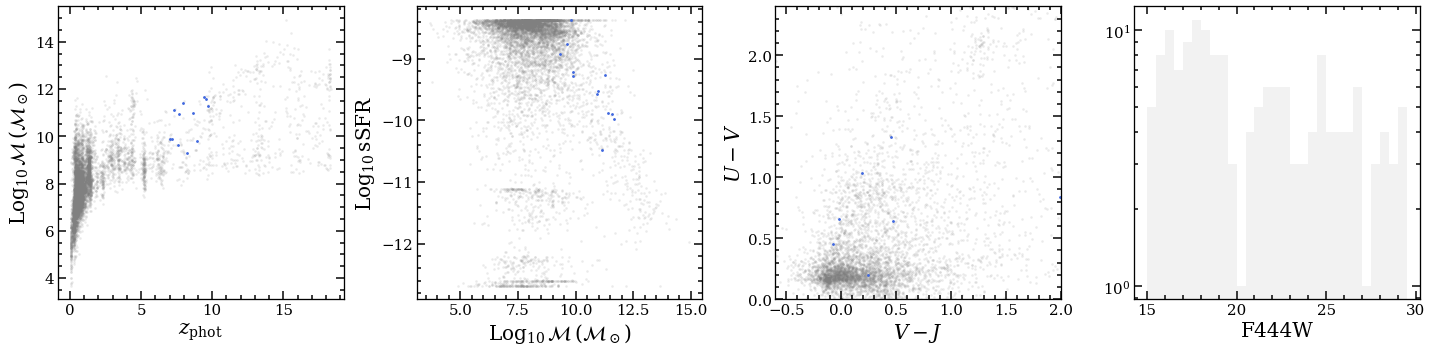

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(4*5, 5))

qg = ez.zout['uvj_class'] == 1
sanity = ez.cat['use_phot'] == 1

# z vs. M
axes[0].scatter(ez.zout['z_phot'][sanity], np.log10(ez.zout['mass'][sanity]), s=3, alpha=0.1, c='grey')
axes[0].scatter(ez.zout['z_phot'][selection], np.log10(ez.zout['mass'][selection]), s=3, c='royalblue')
axes[0].scatter(ez.zout['z_phot'][qg & selection], np.log10(ez.zout['mass'][qg & selection]), s=3, c='orange')
axes[0].set(xlabel='$z_{\\rm phot}$', ylabel='Log$_{10}\,\mathcal{M}\,(\mathcal{M}_\odot)$')

# M vs. SFR
axes[1].scatter(np.log10(ez.zout['mass'][sanity]), np.log10(ez.zout['sfr']/ez.zout['mass'])[sanity], s=3, alpha=0.1, c='grey')
axes[1].scatter(np.log10(ez.zout['mass'][selection]), np.log10(ez.zout['sfr']/ez.zout['mass'])[selection], s=3, c='royalblue')
axes[1].scatter(np.log10(ez.zout['mass'][qg & selection]), np.log10(ez.zout['sfr'][qg & selection]/ez.zout['mass'][qg & selection]), s=3, c='orange')
axes[1].set(xlabel='Log$_{10}\,\mathcal{M}\,(\mathcal{M}_\odot)$', ylabel='Log$_{10}\,{\\rm sSFR}}\,(\mathcal{M}_\odot\,{\\rm yr}^{-1})$')

# UVJ
axes[2].scatter(ez.zout['v_j'][sanity], ez.zout['u_v'][sanity], s=3, alpha=0.1, c='grey')
axes[2].scatter(ez.zout['v_j'][selection], ez.zout['u_v'][selection], s=3, c='royalblue')
axes[2].scatter(ez.zout['v_j'][qg & selection], ez.zout['u_v'][qg & selection], s=3, c='orange')
axes[2].set(xlabel='$V-J$', ylabel='$U-V$', xlim=(-0.6, 2.0), ylim=(0, 2.4))

# F444W
bins = np.arange(15, 30, 0.5)
axes[3].hist(ez.cat['f_f444w'][sanity], bins=bins, alpha=0.1, color='grey')
axes[3].hist(ez.cat['f_f444w'][selection], bins=bins, color='royalblue')
axes[3].hist(ez.cat['f_f444w'][qg & selection], bins=bins, color='orange')
axes[3].set(xlabel='F444W')
axes[3].semilogy()

fig.tight_layout()



In [ ]:
obj

id,x,y,ra,dec,ebv_mw,faper_f444w,eaper_f444w,f_f105w,e_f105w,f_f125w,e_f125w,f_f140w,e_f140w,f_f160w,e_f160w,f_f150w,e_f150w,f_f200w,e_f200w,f_f277w,e_f277w,f_f356w,e_f356w,f_f444w,e_f444w,tot_ekron_F444w,tot_cor,z_spec,star_flag,kron_radius,a_image,b_image,theta_J2000,flux_radius,use_phot
,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
1122,1569.8873572300663,2277.2207439932795,3.634686908292141,-30.422122427837788,0.010685025339626562,0.29503798627767724,0.022421073747457932,--,--,--,--,--,--,--,--,0.34618293490297103,0.0720823637902238,0.32641750943804376,0.05958211986790875,0.22030327035660596,0.03501412393718705,0.4870144861855261,0.03544741804237904,0.4944744859828848,0.03757702205174465,0.008946184430951345,1.6759688886891546,0.0,0,2.343299533945006,2.5349106788635254,1.6978188753128052,-0.18229563534259796,0.16512696469490343,1.0


<SkyCoord (ICRS): (ra, dec) in deg
    (3.63468691, -30.42212243)>


/usr/local/anaconda3/lib/python3.7/site-packages/astropy/stats/sigma_clipping.py:58: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:399: RuntimeWarning: divide by zero encountered in log10
  mag = 25 - 2.5*np.log10(flux)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:400: RuntimeWarning: divide by zero encountered in true_divide
  magerr = 2.5 / np.log(10) / (flux/fluxerr)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:408: RuntimeWarning: All-NaN slice encountered
  scale = np.nanmax(img)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:415: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  ax.text(0.05, 1.05, f'{filt}\n{mag:2.2f}+/-{magerr:2.2f} AB (S/N:{snr:2.2f})', transform=ax.transAxes)
/usr/local/anaconda3/lib/python3.7/site-packages/astropy/stats/sigma_clipping.py:58: RuntimeWarning:

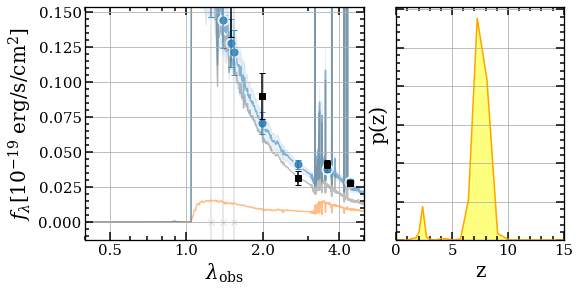

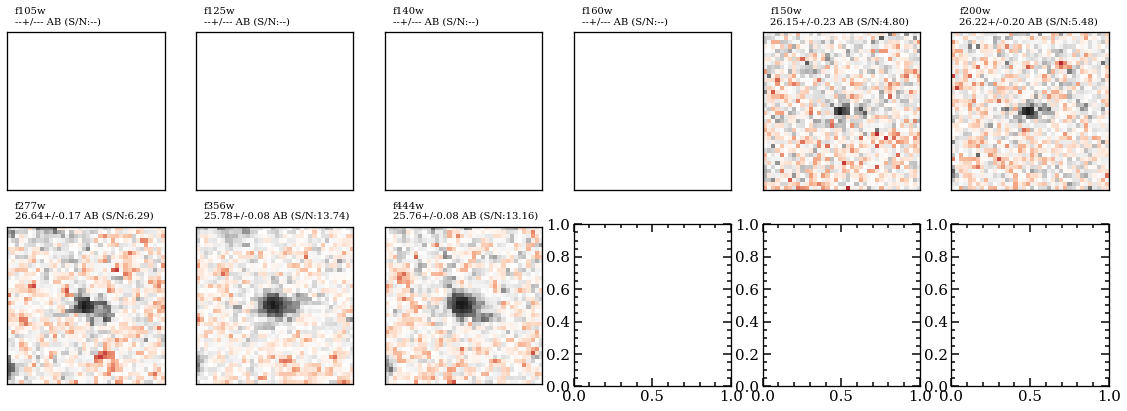

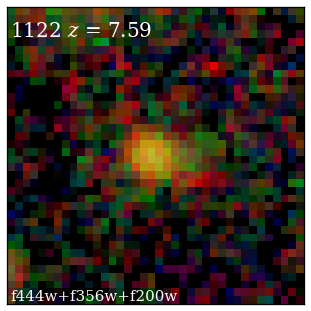

<SkyCoord (ICRS): (ra, dec) in deg
    (3.56894526, -30.40242705)>


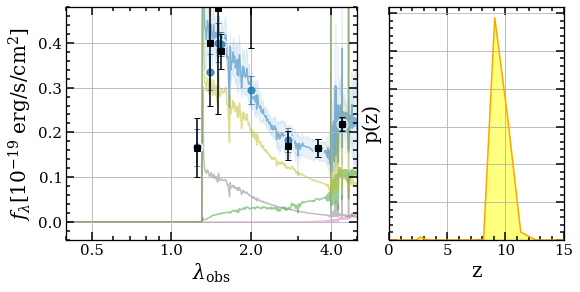

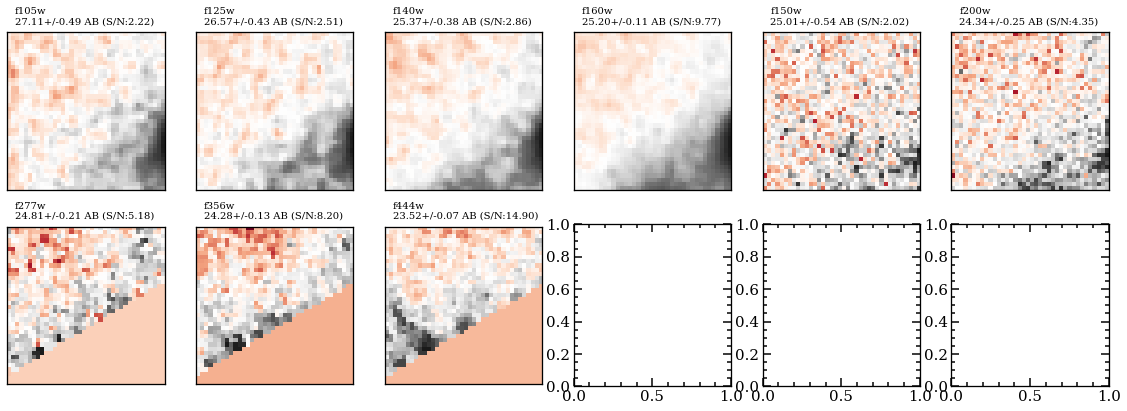

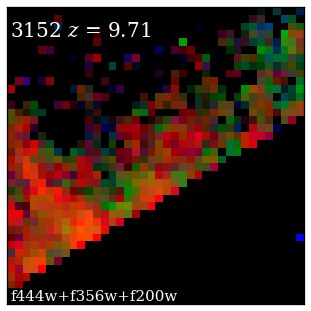

<SkyCoord (ICRS): (ra, dec) in deg
    (3.61250873, -30.40059706)>


/usr/local/anaconda3/lib/python3.7/site-packages/astropy/stats/sigma_clipping.py:58: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:399: RuntimeWarning: divide by zero encountered in log10
  mag = 25 - 2.5*np.log10(flux)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:400: RuntimeWarning: divide by zero encountered in true_divide
  magerr = 2.5 / np.log(10) / (flux/fluxerr)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:408: RuntimeWarning: All-NaN slice encountered
  scale = np.nanmax(img)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:415: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  ax.text(0.05, 1.05, f'{filt}\n{mag:2.2f}+/-{magerr:2.2f} AB (S/N:{snr:2.2f})', transform=ax.transAxes)


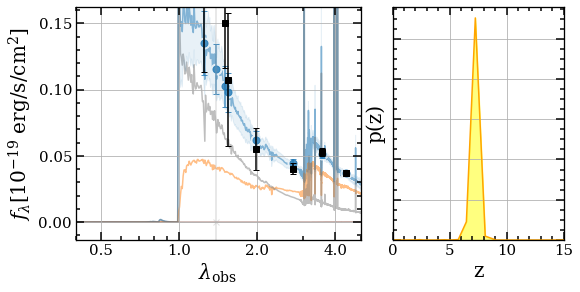

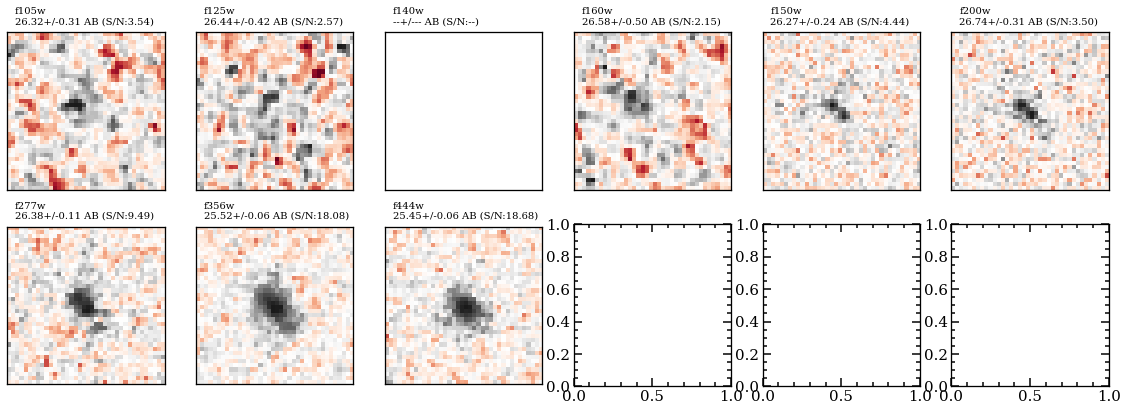

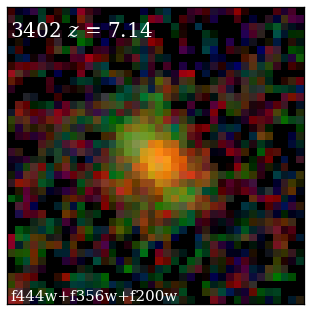

<SkyCoord (ICRS): (ra, dec) in deg
    (3.49786678, -30.38066799)>


/usr/local/anaconda3/lib/python3.7/site-packages/astropy/stats/sigma_clipping.py:58: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:399: RuntimeWarning: divide by zero encountered in log10
  mag = 25 - 2.5*np.log10(flux)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:400: RuntimeWarning: divide by zero encountered in true_divide
  magerr = 2.5 / np.log(10) / (flux/fluxerr)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:408: RuntimeWarning: All-NaN slice encountered
  scale = np.nanmax(img)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:415: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  ax.text(0.05, 1.05, f'{filt}\n{mag:2.2f}+/-{magerr:2.2f} AB (S/N:{snr:2.2f})', transform=ax.transAxes)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:397: RuntimeWarning: divide by zero encoun

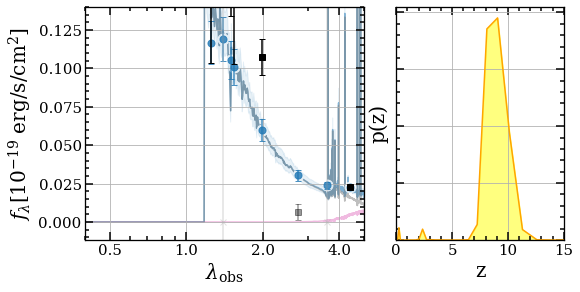

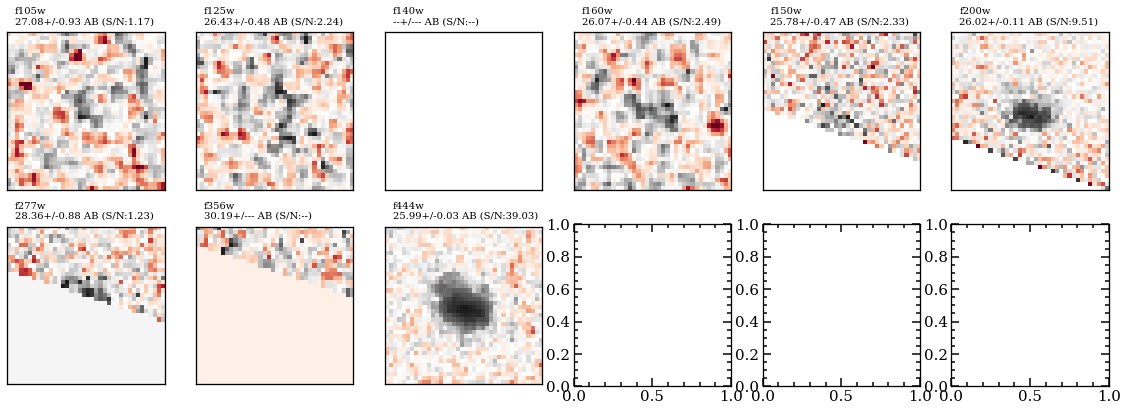

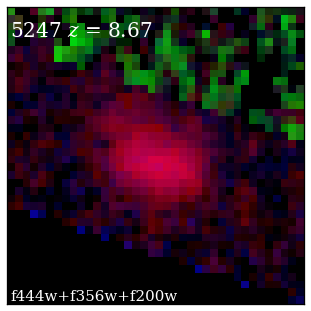

<SkyCoord (ICRS): (ra, dec) in deg
    (3.60694645, -30.38080279)>


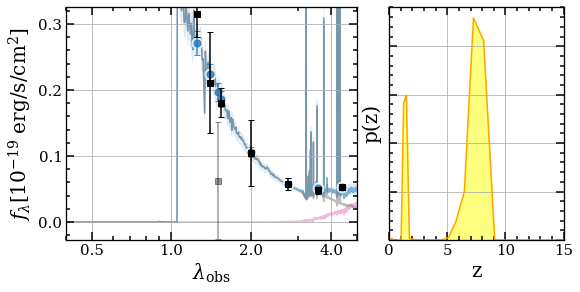

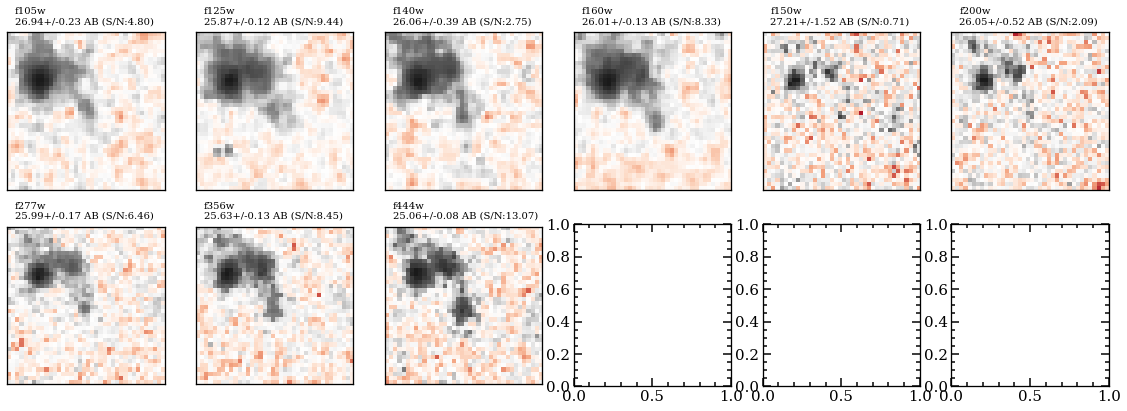

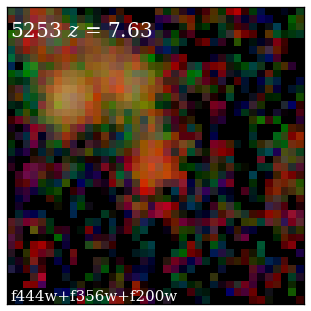

<SkyCoord (ICRS): (ra, dec) in deg
    (3.60134328, -30.37919621)>


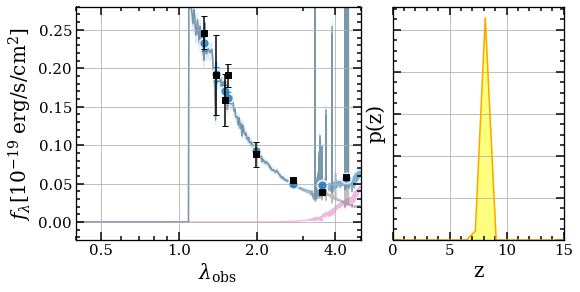

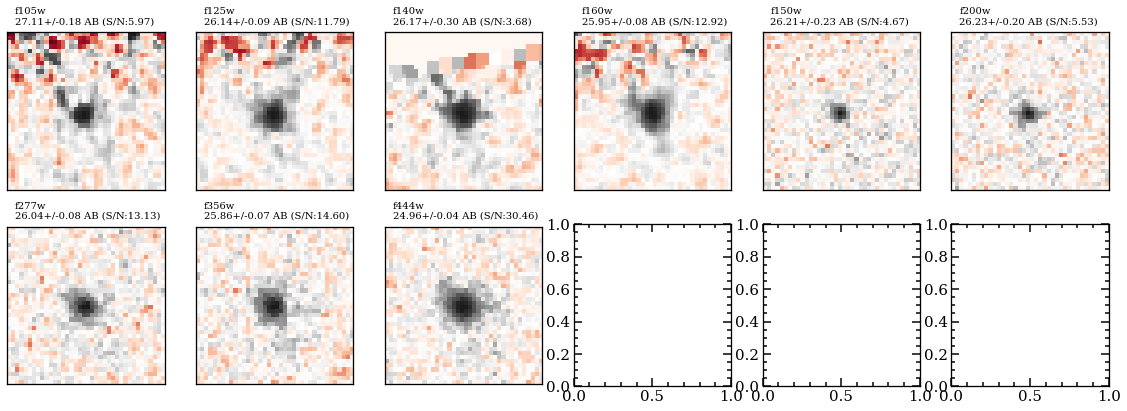

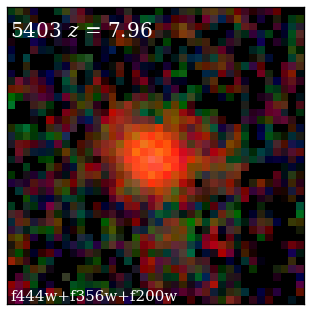

<SkyCoord (ICRS): (ra, dec) in deg
    (3.58789755, -30.37629604)>


/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:399: RuntimeWarning: invalid value encountered in log10
  mag = 25 - 2.5*np.log10(flux)
/usr/local/anaconda3/lib/python3.7/site-packages/astropy/stats/sigma_clipping.py:58: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:399: RuntimeWarning: divide by zero encountered in log10
  mag = 25 - 2.5*np.log10(flux)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:400: RuntimeWarning: divide by zero encountered in true_divide
  magerr = 2.5 / np.log(10) / (flux/fluxerr)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:408: RuntimeWarning: All-NaN slice encountered
  scale = np.nanmax(img)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:415: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  ax.text(0.05, 1.05, f'{filt}\n{mag:2.2f}+/-{magerr:2.2f} 

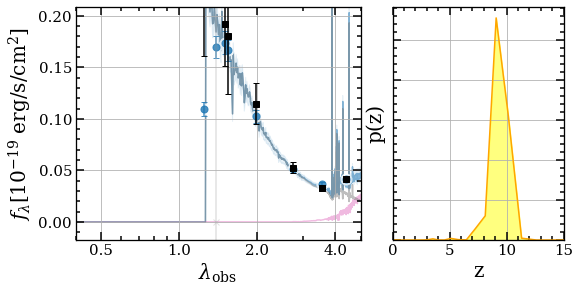

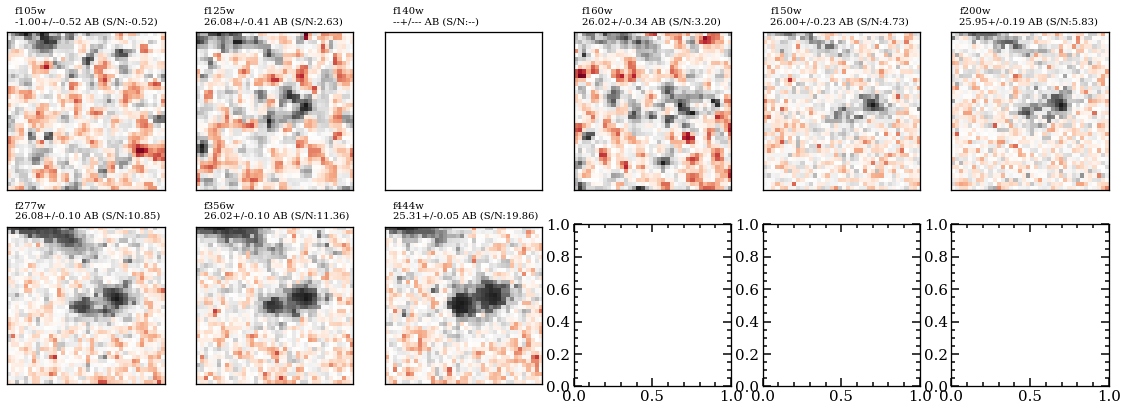

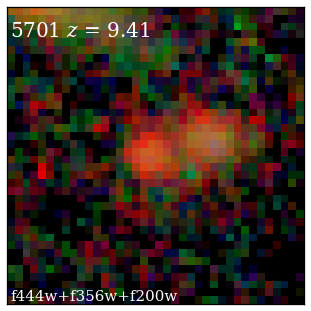

<SkyCoord (ICRS): (ra, dec) in deg
    (3.58780725, -30.37627621)>


/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:399: RuntimeWarning: invalid value encountered in log10
  mag = 25 - 2.5*np.log10(flux)
/usr/local/anaconda3/lib/python3.7/site-packages/astropy/stats/sigma_clipping.py:58: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:399: RuntimeWarning: divide by zero encountered in log10
  mag = 25 - 2.5*np.log10(flux)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:400: RuntimeWarning: divide by zero encountered in true_divide
  magerr = 2.5 / np.log(10) / (flux/fluxerr)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:408: RuntimeWarning: All-NaN slice encountered
  scale = np.nanmax(img)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:415: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  ax.text(0.05, 1.05, f'{filt}\n{mag:2.2f}+/-{magerr:2.2f} 

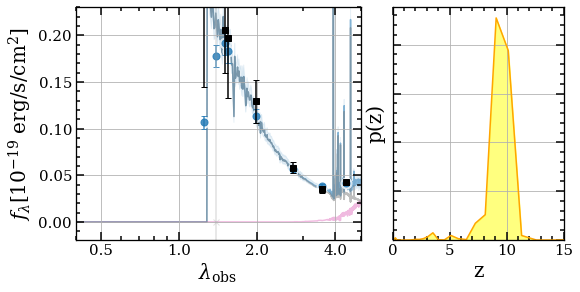

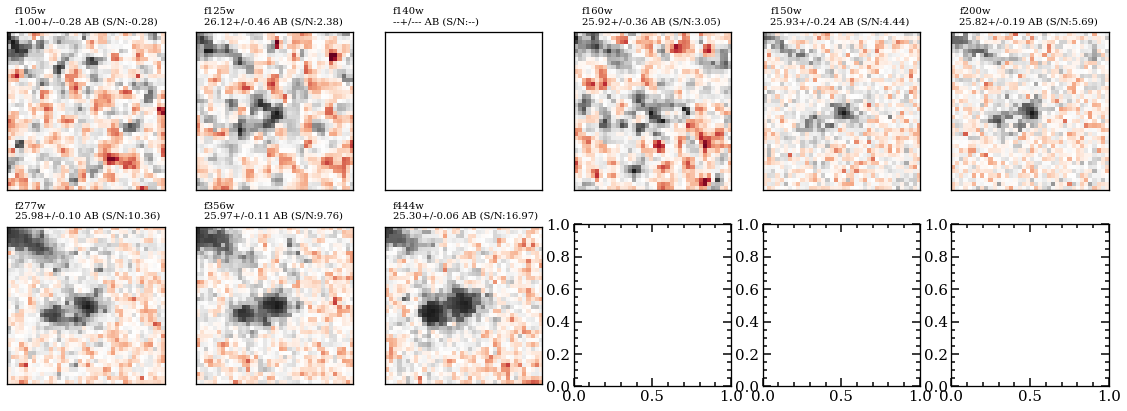

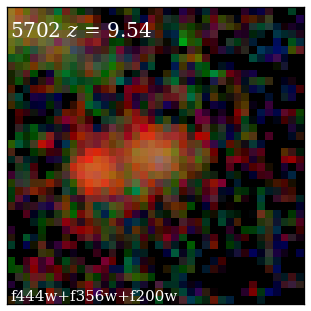

<SkyCoord (ICRS): (ra, dec) in deg
    (3.52891497, -30.3714366)>


/usr/local/anaconda3/lib/python3.7/site-packages/astropy/stats/sigma_clipping.py:58: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:399: RuntimeWarning: divide by zero encountered in log10
  mag = 25 - 2.5*np.log10(flux)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:400: RuntimeWarning: divide by zero encountered in true_divide
  magerr = 2.5 / np.log(10) / (flux/fluxerr)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:408: RuntimeWarning: All-NaN slice encountered
  scale = np.nanmax(img)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:415: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  ax.text(0.05, 1.05, f'{filt}\n{mag:2.2f}+/-{magerr:2.2f} AB (S/N:{snr:2.2f})', transform=ax.transAxes)
/usr/local/anaconda3/lib/python3.7/site-packages/astropy/stats/sigma_clipping.py:58: RuntimeWarning:

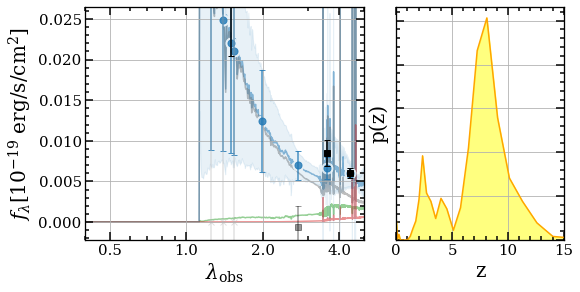

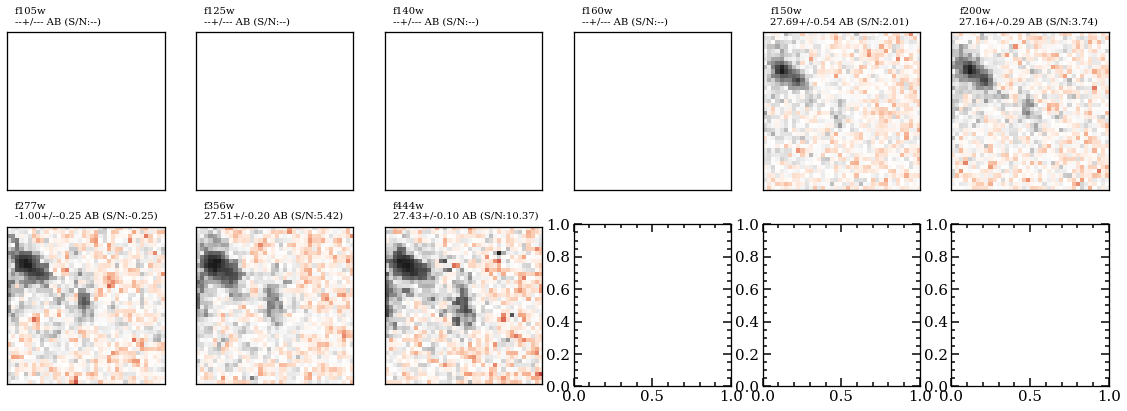

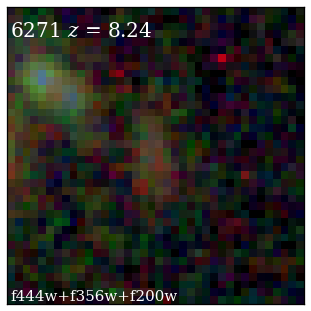

<SkyCoord (ICRS): (ra, dec) in deg
    (3.51180812, -30.34684764)>


/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:399: RuntimeWarning: invalid value encountered in log10
  mag = 25 - 2.5*np.log10(flux)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:399: RuntimeWarning: invalid value encountered in log10
  mag = 25 - 2.5*np.log10(flux)
/usr/local/anaconda3/lib/python3.7/site-packages/astropy/stats/sigma_clipping.py:58: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:399: RuntimeWarning: divide by zero encountered in log10
  mag = 25 - 2.5*np.log10(flux)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:400: RuntimeWarning: divide by zero encountered in true_divide
  magerr = 2.5 / np.log(10) / (flux/fluxerr)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:408: RuntimeWarning: All-NaN slice encountered
  scale = np.nanmax(img)
/Users/jweaver/Projects/Software/aperpy/src/webb_tools.py:415: FutureWarning: Format strings passe

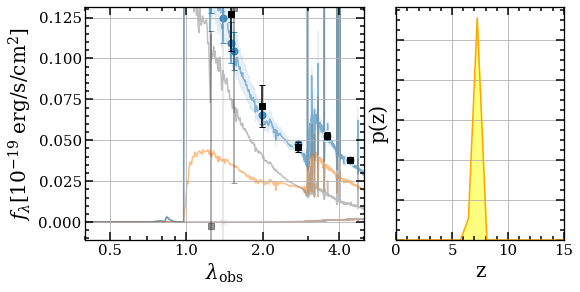

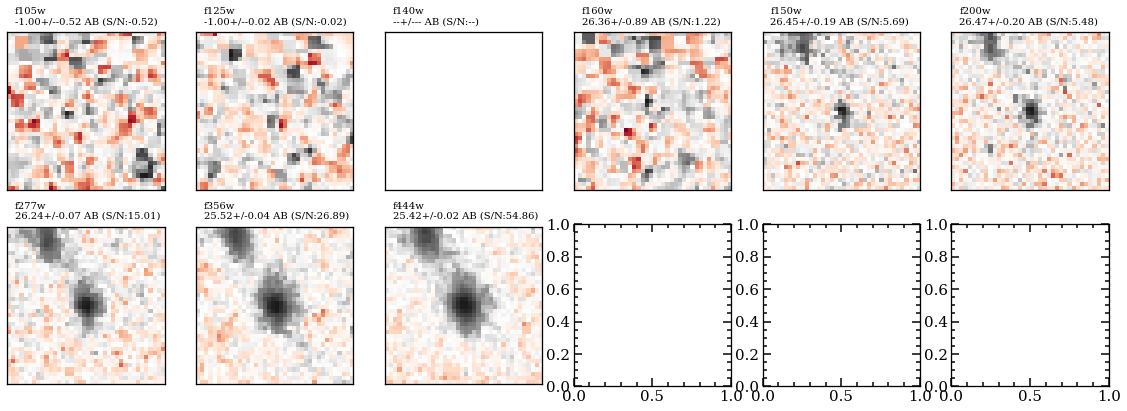

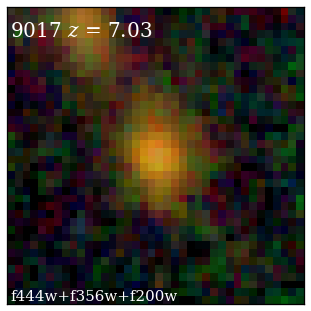

In [ ]:
from aperpy.src.webb_tools import make_cutout
import matplotlib.pyplot as plt

for obj in ez.cat[selection][:10]:
    id = obj['id']
    fig, data = ez.show_fit(id, xlim=[0.4, 5], show_components=True,
                              logpz=False, zr=[0,15], show_fnu=False, add_label=False) #, zshow=self.cat['z_spec'][sel][so][i])
    
    ra, dec = obj['ra'], obj['dec']
    make_cutout(ra, dec, 1.5, id, FILTERS, DIR_OUTPUT, row=obj, rgb=['f444w', 'f356w', 'f200w'], write=False, include_rgb=True, redshift=data['z'])

    plt.pause(0.01)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


[(-0.3, 0.3),
 (0.1, 5.0),
 Text(0.5, 0, 'Observed Wavelength ($\\mu$m)'),
 Text(0, 0.5, 'Flux $\\frac{\\rm{observed}-\\rm{model}}{\\rm{model}}$')]

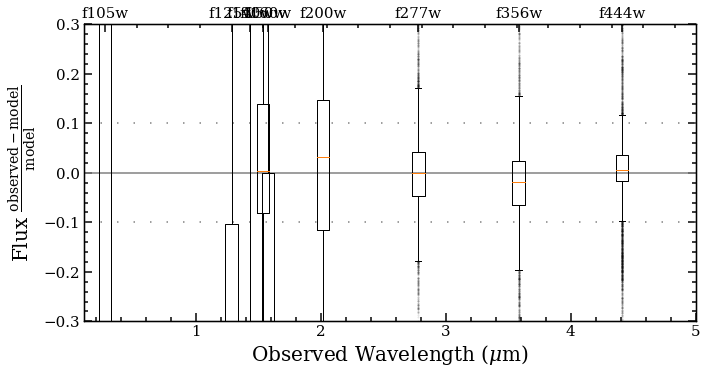

In [119]:
diff = ez.fnu - ez.fmodel
rel_diff = diff / ez.fmodel

sanity = ez.cat['use_phot'] == 1

# for i, fname in enumerate(ez.filters):
#     for filt in FILTERS:
#         if filt in str(fname):
#             break
#     print(filt)
    
#     plt.scatter(ez.pivot[i]*np.ones(len(rel_diff)), rel_diff[:,i], s=1, alpha=0.1, c='grey')
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(0, ls='solid', c='grey')
ax.axhline(0.1, ls=(0, (1, 10)), c='grey')
ax.axhline(-0.1, ls=(0, (1, 10)), c='grey')
axt = ax.twiny()
axt.boxplot(rel_diff[sanity], vert=True, positions=ez.pivot*1e-4, widths=0.1, labels=FILTERS, flierprops={'marker':'.', 'markersize':2, 'alpha':0.1})
axt.set(xlim=(0.05, 5))
ax.set(ylim=(-0.3, 0.3), xlim=(0.1, 5), xlabel='Observed Wavelength ($\mu$m)', ylabel='Flux $\\frac{\\rm{observed}-\\rm{model}}{\\rm{model}}$')



f105w hst/wfc3/UVIS/f218w.dat calcband_wfc3-uvis1-f218w lambda_c= 2.2272e+03 AB-Vega= 1.690 w95=467.2
f125w hst/wfc3/IR/f125w.dat lambda_c= 1.2471e+04 AB-Vega= 0.895 w95=2867.0
f140w hst/wfc3/IR/f140w.dat lambda_c= 1.3924e+04 AB-Vega= 1.072 w95=3759.7
f160w hst/wfc3/IR/f160w.dat lambda_c= 1.5396e+04 AB-Vega= 1.250 w95=2743.9
f150w jwst_nircam_f150w v20160902164019 lambda_c= 1.5007e+04
f200w jwst_nircam_f200w v20160902164019 lambda_c= 1.9886e+04
f277w jwst_nircam_f277w v20160902164019 lambda_c= 2.7623e+04
f356w jwst_nircam_f356w v20160902164019 lambda_c= 3.5682e+04
f444w jwst_nircam_f444w v20160902164019 lambda_c= 4.4037e+04


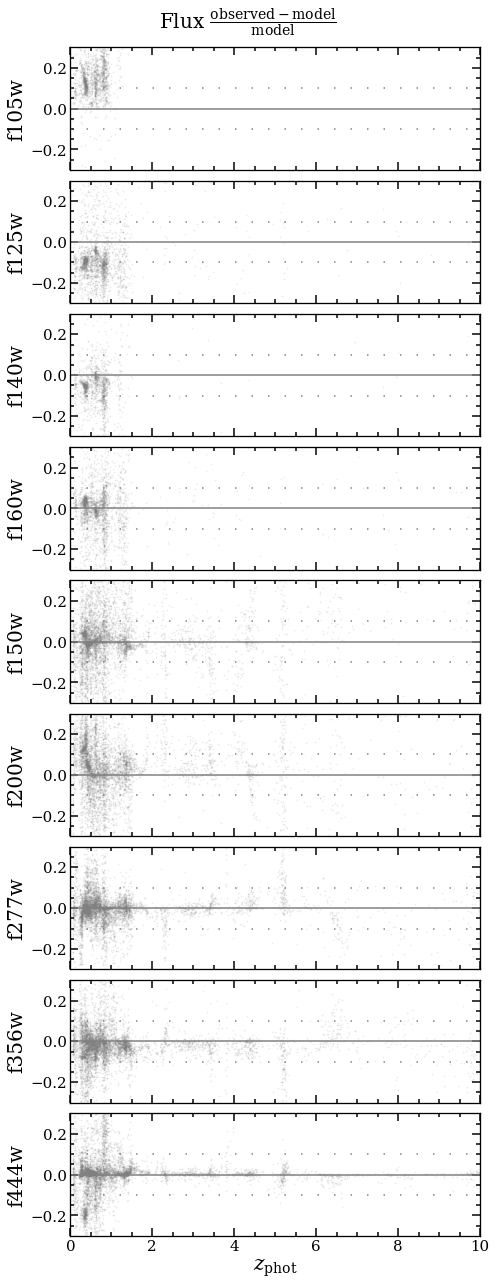

In [143]:
fig, axes = plt.subplots(nrows=ez.NFILT, figsize=(7, 2*ez.NFILT), sharey=True, sharex=True)
axes[-1].set(xlim=(0, 10), ylim=(-0.3, 0.3),
    xlabel='$z_{\\rm phot}$')
fig.suptitle('Flux $\\frac{\\rm{observed}-\\rm{model}}{\\rm{model}}$', y=0.99, fontsize=20)

from webb_tools import histedges_equalN, running_med

for i, (filt, fname, ax) in enumerate(zip(FILTERS, ez.filters, axes)):
    print(filt, fname)

    ax.axhline(0, ls='solid', c='grey')
    ax.axhline(0.1, ls=(0, (1, 10)), c='grey')
    ax.axhline(-0.1, ls=(0, (1, 10)), c='grey')

    ax.set_ylabel(filt)

    

    ax.scatter(ez.zbest[sanity], rel_diff[sanity, i], c='grey', s=1, alpha=0.1)
    # ax

fig.tight_layout()

In [122]:
ez.NFILT

9